In [1]:
import pandas as pd
import numpy as np
from pandas_datareader import data
from pylab import plt
# the above line has the same effect as
#import matplotlib.pyplot as plt
import yfinance as yf
yf.pdr_override()

In [2]:
df = data.get_data_yahoo(tickers='^HSI',start='2012-01-01', end='2022-12-31')
df = df['Close']
df

[*********************100%***********************]  1 of 1 completed


Date
2012-01-03    18877.410156
2012-01-04    18727.310547
2012-01-05    18813.410156
2012-01-06    18593.060547
2012-01-09    18865.720703
                  ...     
2022-12-22    19679.220703
2022-12-23    19593.060547
2022-12-28    19898.910156
2022-12-29    19741.140625
2022-12-30    19781.410156
Name: Close, Length: 2708, dtype: float64

In [3]:
#To reduce the running time
df = df[:1500]

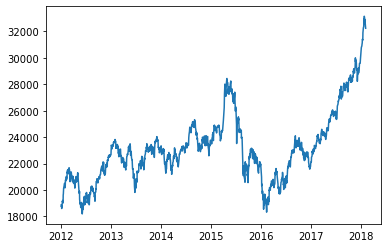

In [4]:
plt.plot(df)

In [20]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
rdata = scaler.fit_transform(np.array(df).reshape(-1,1))
training_size=int(len(rdata)*0.80)
train_period,test_period=rdata[:training_size],rdata[training_size:]

In [21]:
from keras.preprocessing.sequence import TimeseriesGenerator
train = TimeseriesGenerator(train_period, train_period, length=10, batch_size=1500)
test = TimeseriesGenerator(test_period, test_period, length=10, batch_size=1500)
X_train, y_train = list(train)[0][0], list(train)[0][1]
X_test, y_test = list(test)[0][0], list(test)[0][1]

In [22]:
from numpy import insert
# Delete the first four values of y_train
y_train = np.delete(y_train,[0,1,2,3,],axis = 0)
len(y_train)

1186

In [23]:
# Delete the last four time series of X_train. 
# In this way, the stock price of the first ten days can be used to predict the stock price of the fifteenth day
X_train = X_train[:-4, :]
len(X_train)

1186

In [24]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [25]:
model=Sequential() 
model.add(LSTM(50,return_sequences=True,activation='relu',input_shape=(10,1))) 
model.add(LSTM(50,return_sequences=True)) 
model.add(LSTM(50)) 
model.add(Dense(1)) 
model.compile(loss='mean_squared_error',optimizer='adam')

In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 10, 50)            10400     
                                                                 
 lstm_4 (LSTM)               (None, 10, 50)            20200     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [32]:

model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=20,batch_size=64,verbose=True)

Epoch 1/20
19/19 [==============================] - 1s 58ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 2/20
19/19 [==============================] - 1s 51ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 3/20
19/19 [==============================] - 1s 51ms/step - loss: 0.0018 - val_loss: 5.1470e-04
Epoch 4/20
19/19 [==============================] - 1s 51ms/step - loss: 0.0018 - val_loss: 4.5689e-04
Epoch 5/20
19/19 [==============================] - 1s 52ms/step - loss: 0.0019 - val_loss: 4.2206e-04
Epoch 6/20
19/19 [==============================] - 1s 51ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 7/20
19/19 [==============================] - 1s 51ms/step - loss: 0.0017 - val_loss: 8.8178e-04
Epoch 8/20
19/19 [==============================] - 1s 51ms/step - loss: 0.0017 - val_loss: 3.5806e-04
Epoch 9/20
19/19 [==============================] - 1s 52ms/step - loss: 0.0017 - val_loss: 3.7336e-04
Epoch 10/20
19/19 [==============================] - 1s 51ms/step - loss: 0.0018 - va

In [33]:
train_predict = scaler.inverse_transform(model.predict(X_train))
test_predict = scaler.inverse_transform(model.predict(X_test))

10/10 [==============================] - 0s 13ms/step


<function matplotlib.pyplot.show(close=None, block=None)>

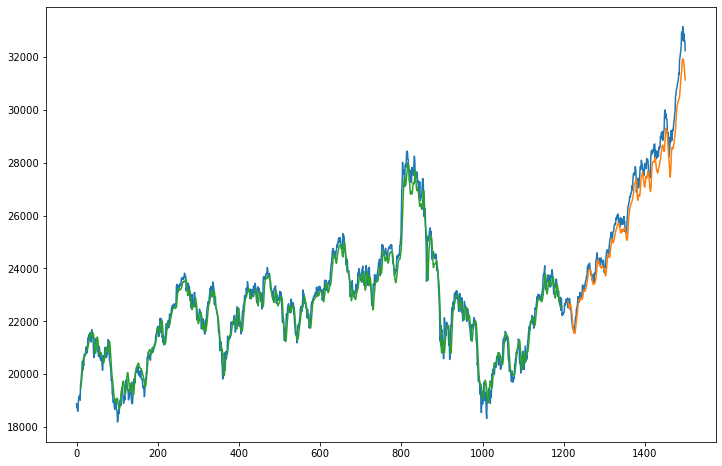

In [34]:
look_back=10
trainPredictPlot=np.empty_like(rdata)
trainPredictPlot[:,:]=np.nan
trainPredictPlot[look_back:len(train_predict)+look_back] = train_predict

testPredictPlot=np.empty_like(rdata)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+4:len(rdata)] = test_predict


plt.figure(figsize=(12,8))
plt.plot(scaler.inverse_transform(rdata))
plt.plot(testPredictPlot)
plt.plot(trainPredictPlot)

plt.show


In [35]:
testPredictPlot.shape


(1500, 1)

<function matplotlib.pyplot.show(close=None, block=None)>

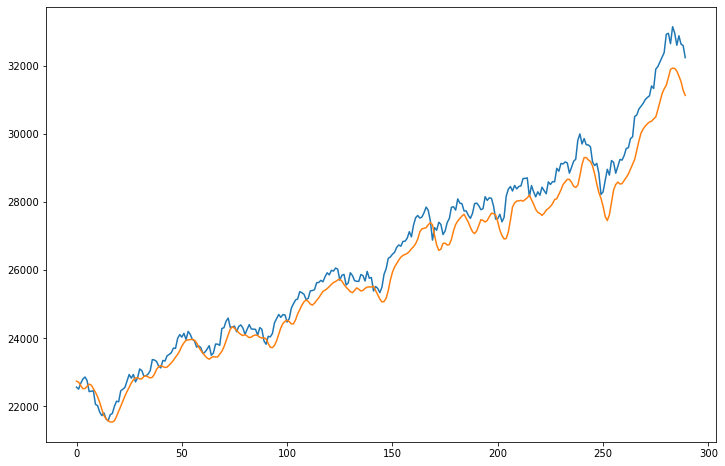

In [36]:
plt.figure(figsize=(12,8))
plt.plot(scaler.inverse_transform(rdata)[len(train_predict)+(look_back*2)+4:len(rdata)])

plt.plot(test_predict)
plt.show

In [37]:
np.sum(abs(test_predict-y_test))

7544155.421845356